# NDF算法研究测试报告

In [67]:
from Module import *

from xcw_package import Signal,Plot,BasicSP
from xcw_package.Plot import plot_spectrum

## 1. 测试数据导入

In [12]:
from scipy.io import loadmat


def CWRU_readdata(
    fau_pos: str,
    fau_type: str,
    size: str,
    load: str,
    clock: str = "0",
    file_pos: str = r"...",
) -> np.ndarray:
    """
    读取CWRU实验数据

    参数: 
    --------
    fau_pos: str
        故障位置, 可选值为"FE","DE12K","DE48K"
    fau_type: str
        故障类型, 可选值为"B","IR","OR"
    size: str
        故障大小, 可选值为"07","14","21","28"
    load: str
        负载, 可选值为"0","1","2","3"
    clock: str
        故障方向, 当故障类型选为OR时可选值为"6","12","3"
    file_pos: str
        数据集文件夹路径
    
    返回:
    --------
    RPM: int
        转速
    DE: np.ndarray
        驱动端数据
    FE: np.ndarray
        风扇端数据
    BA: np.ndarray
        基座数据
    """
    fau_pos_dict = {
        "FE": "12k Fan End Bearing Fault Data",
        "DE12K": "12k Drive End Bearing Fault Data",
        "DE48K": "48k Drive End Bearing Fault Data",
    }
    fau_type_dict = {"B": "Ball", "IR": "Inner Race", "OR": "Outer Race"}
    clock_dict = {"6": "Centered", "12": "Opposite", "3": "Orthogonal"}
    size_dict = {"07": "0007", "14": "0014", "21": "0021", "28": "0028"}
    load_dict = {"0": "0", "1": "1", "2": "2", "3": "3"}
    file = ""
    file_name = ""
    # -----------------------------------------------------------------------------------#
    if fau_pos not in fau_pos_dict.keys():  # 判断故障位置参数是否正确
        raise ValueError("fau_pos参数错误")
    else:
        file = file_pos+'\\' + fau_pos_dict[fau_pos]

    if fau_type not in fau_type_dict.keys():  # 判断故障类型参数是否正确
        raise ValueError("fau_type参数错误")
    elif fau_type == "OR":
        if clock not in clock_dict.keys():
            raise ValueError("clock参数错误")
        else:
            file += "\\" + fau_type_dict[fau_type] + "\\" + clock_dict[clock]
    else:
        file += "\\" + fau_type_dict[fau_type]

    if size not in size_dict.keys():  # 判断故障大小参数是否正确
        raise ValueError("size参数错误")
    else:
        file += "\\" + size_dict[size]
    # -----------------------------------------------------------------------------------#
    if load not in load_dict.keys():  # 判断负载参数是否正确
        raise ValueError("load参数错误")

    file_name = fau_type + "0" + size
    if fau_type == "OR":
        file_name += "@" + clock
    file_name += "_" + load + ".mat"  # 生成mat文件名
    # -----------------------------------------------------------------------------------#
    file = file + ("\\" + file_name)  # 生成文件路径
    print(f"尝试读取文件路径:{file}")
    try:
        data = loadmat(file)  # 由于某些参数下没有实验数据，故使用try读取文件
    except FileNotFoundError:
        raise FileNotFoundError("不存在该参数下实验数据文件")
    print("成功读取文件")
    keys = data.keys()
    RPM = [s for s in keys if "RPM" in s][0]
    DE = [s for s in keys if "DE" in s][0]
    FE = [s for s in keys if "FE" in s][0]
    BA = [s for s in keys if "BA" in s]

    RPM = data[RPM][0][0]  # 读取转速
    DE = data[DE].flatten()  # 读取驱动端数据
    FE = data[FE].flatten()  # 读取风扇端数据
    if len(BA) != 0:
        BA = data[BA[0]].flatten()  # 读取基座数据
    print(
        f"该实验转速参数:{RPM}rpm\n驱动端DE数据长度:{len(DE)}\n风扇端FE数据长度:{len(FE)}\n基座BA数据长度:{len(BA)}"
    )
    return RPM, DE, FE, BA

In [13]:
res=CWRU_readdata('DE12K','OR','14','1','6',r"D:\OneDrive\UserFiles\工作\故障诊断数据库\CRWU-bearing")

尝试读取文件路径:D:\OneDrive\UserFiles\工作\故障诊断数据库\CRWU-bearing\12k Drive End Bearing Fault Data\Outer Race\Centered\0014\OR014@6_1.mat
成功读取文件
该实验转速参数:1772rpm
驱动端DE数据长度:122136
风扇端FE数据长度:122136
基座BA数据长度:122136


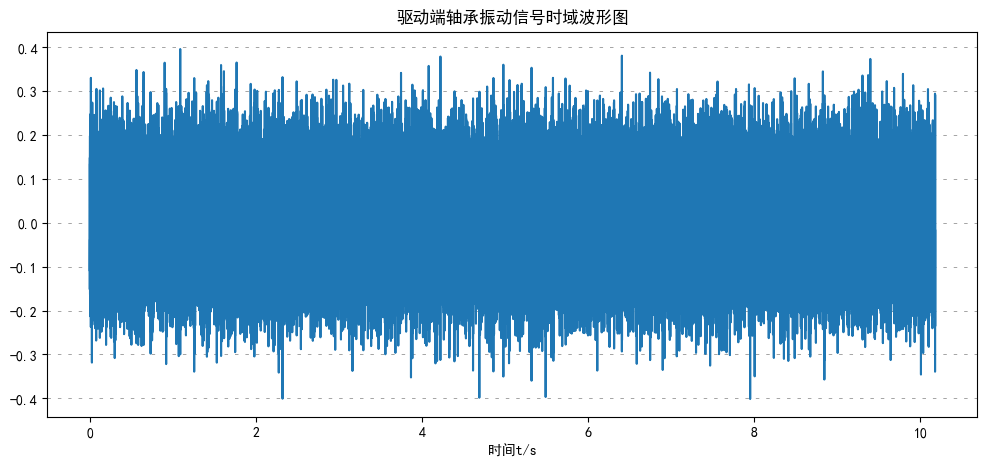

In [14]:
Sig_DE=Signal.Signal(data=res[1],label='驱动端轴承振动信号',fs=12000)
Sig_DE.plot()

## 2. 算法源代码

### 2.1 二阶自适应扩散滤波

In [89]:
class NDF_Analysis():
    def __init__(self):
        pass

    def SA_NDF(self,data:np.ndarray,fs:int,WinSize:float,SegNum,kappa:float,iters:int,dt:float,plot:bool=False):
        thre=self.SegPower(data,fs,WinSize,SegNum)*kappa

        G_win=self.Gaussian(WinSize,int(WinSize*fs))
        filted_data=data.copy()#迭代初始化
        Delta=_Delta=np.zeros_like(data)
        for i in range(iters):
            Coe=self.DiffusionCoe(data,thre,G_win,)
            D2_data=self.Div2(filted_data)#信号二阶导
            Delta=Coe*D2_data*dt#扩散方程迭代单步增量
            filted_data+=Coe*D2_data*dt#扩散方程迭代

            if np.linalg.norm(Delta-_Delta)<1e-5:
                break
            else:
                _Delta=Delta.copy()

        print(f"迭代次数:{i+1}")
        
        if plot:
            t_Axis=np.arange(len(data))/fs
            plot_spectrum(t_Axis,filted_data)
        return filted_data


    def Gaussian(self,T:float,N:int):
        if N%2==0:
            t_Axis=np.linspace(-T/2,T/2,N,endpoint=False)
        else:
            t_Axis=np.linspace(-T/2,T/2,N,endpoint=True)
        sigma=(t_Axis[-1]-t_Axis[0]/2)
        window=np.exp(-t_Axis**2/(2*sigma**2))
        window/=np.sum(window)#归一化
        return window

    def SegPower(self,data:np.ndarray,fs:int,size:float,n:int):
        G_win = self.Gaussian(size, int(size * fs))
        Powerflow = np.convolve(np.square(data), G_win, mode="same")
        PowerflowSeg = np.array_split(Powerflow, n)#分段功率流
        seg_power = [Seg.mean() for Seg in PowerflowSeg]
        return seg_power
    
    def DiffusionFunc(self,E:np.ndarray,lam:float):
        return (1-(E/lam)**2)/(1+0.5*(E/lam)**4)
    
    def DiffusionCoe(self,data:np.ndarray,threshold:list,window:np.ndarray):
        Feature=np.convolve(np.square(data),window,'same')#扩散控制特征
        # 分段计算扩散系数，实现自适应性
        FeatureSeg=np.array_split(Feature,len(threshold))#按阈值分段
        Coe=[]
        for i,seg in enumerate(FeatureSeg):#每个区间单独计算自适应阈值下的扩散系数
            CoeSeg=self.DiffusionFunc(seg,threshold[i])
            Coe.append(CoeSeg)
        Coe=np.concatenate(Coe)#合并得到整体扩散系数
        return Coe

    def Div2(self,data:np.ndarray):
        kernel=[-1/12,4/3,-5/2,4/3,-1/12]#二阶导数的5点差分系数
        return np.convolve(data,kernel,'same')



## 3. 测试

迭代次数:100


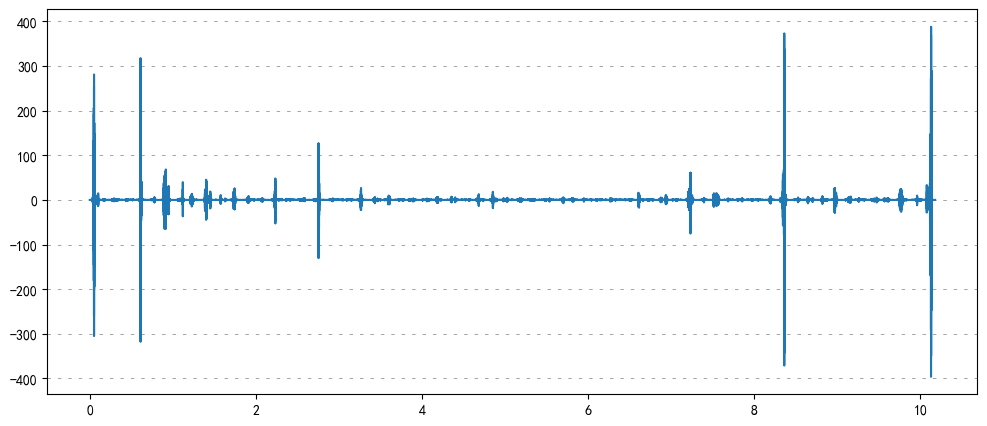

In [91]:
NDF=NDF_Analysis()
filted_data=NDF.SA_NDF(Sig_DE.data,12000,0.1,100,1,100,0.1,plot=True)